In [18]:
""" Assignment 1: Geometrical transforms
            a) Transform the given image using Rotation, Affine, Homography transforms.
                You can test with different parameters in each case. 

            b) Estimate the homography / affine transform using examples created in the first assignment.
                For part b)  will have to manually select corresponding points in the reference image and the transformed image.
                
Explore some mouse based selection tools in whichever programming environment you work with."""

import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
from scipy import ndimage
from PIL import Image

def get_new_bounds(original_shape, rot_matrix):
    """
    Calculate the boundaries of the new image
    Args:
        original_shape (tuple): Shape of original image in (H, W)
        rot_matrix: A 2*3 rotation matrix
    Returns:
        x_min, x_max, y_min, y_max :
    """
    assert len(original_shape) == 2
    points = [[0, 0], [original_shape[1], 0], [0, original_shape[0]],
              [original_shape[1], original_shape[0]]]
    new_points = [rotate_pt((pt[0], pt[1]), rot_matrix) for pt in points]

    h_min = np.min([x[0] for x in new_points])
    h_max = np.max([x[0] for x in new_points])

    w_min = np.min([y[1] for y in new_points])
    w_max = np.max([y[1] for y in new_points])
    return h_min, h_max, w_min, w_max


def rotate_pt(pt, rot_matrix):
    """
    Rotates a point
    :param pt: (H, W co-ordinate of point to rotate)
    :param rot_matrix: A 2*3 rotation matrix
    :return: (h, w) co-ordinates of new point
    """
    h, w = pt
    a, b, c, d, e, f = rot_matrix
    i, j = a * h + b * w + c, d * h + e * w + f
    new_point = int(i), int(j)
    return new_point


def check_bounds(point, shape):
    """
    Checks if a point is in bounds of a shape
    :param point: (H co-ordinate , W, co-ordinate)
    :param shape: (H, W)
    :return:
    """
    x_min = 0
    x_max = shape[1]
    y_min = 0
    y_max = shape[0]
    if (point[1] <= x_min) or (point[1] >= x_max):
        return True
    elif (point[0] <= y_min) or (point[0] >= y_max):
        return True
    else:
        return False


def get_rotation_matrix(image, angle, adjust_boundaries=True):
    """
    #T(x,y)∗R∗T(−x,−y)(P)
    Calculates the 2D rotation matrix
    :param image: An image in (H, W) shape
    :param angle: Angle of rotation in degrees
    :return: The 2D rotation matrix
    """
    angle = np.deg2rad(angle)

    h, w = image.shape
    cy, cx = h / 2, w / 2

    a = np.math.cos(angle)
    b = np.math.sin(angle)
    xc1 = -cx
    xc2 = cx
    yc1 = -cy
    yc2 = cy

    rot_matrix = [
        a, -b, xc1 * a - yc1 * b + xc2, b, a, xc1 * b + yc1 * a + yc2
    ]

    if adjust_boundaries:
        x_min, x_max, y_min, y_max = get_new_bounds((h, w), rot_matrix)
        new_img = np.zeros((y_max - y_min, x_max - x_min))

        new_h, new_w = new_img.shape
        yc_new, xc_new = new_h / 2, new_w / 2

        y_shift = cy - yc_new
        x_shift = cx - xc_new

        rot_matrix[2] -= x_shift
        rot_matrix[5] -= y_shift

    return rot_matrix


def rotate_image(image, rot_matrix):
    """
    Rotates a given image
    :param image: A grayscale image in (H, W) format
    :param rot_matrix: a 2 * 3 rotation matrix
    :return: Rotated image
    """
    h_min, h_max, w_min, w_max = get_new_bounds(
        (image.shape[0], image.shape[1]), rot_matrix)
    new_image = np.zeros((h_max, w_max))
    for i in range(0, image.shape[0]):
        for j in range(0, image.shape[1]):
            new_point = rotate_pt((j, i), rot_matrix)
            if check_bounds((new_point[1], new_point[0]), new_image.shape):
                continue
            else:
                new_image[new_point[1]][new_point[0]] = image[i][j]
    return new_image

In [20]:

from PIL import Image
import numpy as np

img = np.asarray(Image.open("a4-checkerboard.png").convert('L'))
rot_matrix = get_rotation_matrix(img, angle=45, adjust_boundaries=True)
rotated_image = rotate_image(img, rot_matrix)
output_image = Image.fromarray(rotated_image.astype("uint8"))
output_image.save("rotated_image22.png")
im = Image.open("rotated_image22.png")
im.show()

In [ ]:
##############################################################################################################################

                                    """Affine Transformation"""

In [9]:
%matplotlib notebook
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_grid(x, y, homogenous=False):
    coords = np.indices((x, y)).reshape(2, -1)
    return np.vstack((coords, np.ones(coords.shape[1]))).astype(np.int) if homogenous else coords

def grid_plotter(points, labels):
    markers = ['o', 'x', 's', '^', 'p', 'v']
    fig, ax = plt.subplots(figsize=(8,6))
    for i, p in enumerate(points):
        x, y = p[0], p[1]
        ax.scatter(x, y, label=labels[i], marker=markers[i], alpha=0.8, s=100)
    ax.legend(loc='lower right')
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)

    ax.grid(True)
    plt.show()
    
def show_image(image):
    fig, ax = plt.subplots(figsize=(8,6))
    ax.imshow(image)
    plt.show()

In [10]:
# Define Transformations
def get_rotation(angle):
    angle = np.radians(angle)
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle),  np.cos(angle), 0],
        [0, 0, 1]
    ])
def get_translation(tx, ty):
    return np.array([
        [1, 0, tx],
        [0, 1, ty],
        [0, 0, 1]
    ])

def get_scale(s):
    return np.array([
        [s, 0, 0],
        [0, s, 0],
        [0, 0, 1]
    ])



<IPython.core.display.Javascript object>


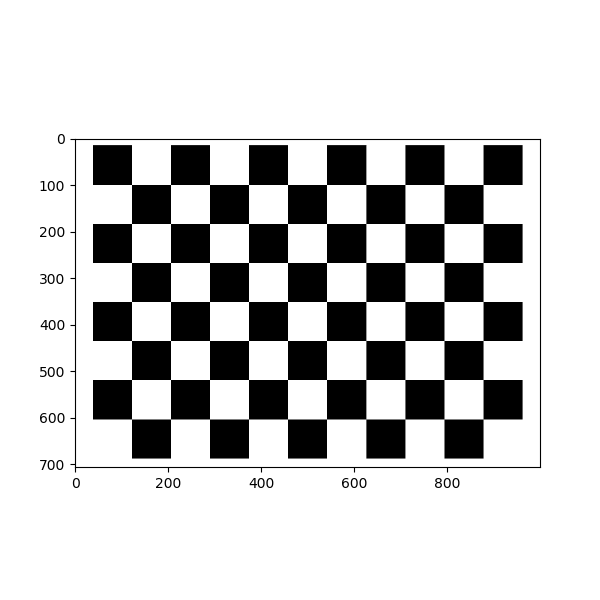

In [11]:
image_path = 'a4-checkerboard.png'
image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (512, 256))
    
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(image)
plt.show()

In [12]:
height, width = image.shape[:2]
tx, ty = np.array((width // 2, height // 2))
angle = np.radians(45)
scale = 2.0


In [13]:
R = np.array([
    [np.cos(angle), np.sin(angle), 0],
    [-np.sin(angle), np.cos(angle), 0],
    [0, 0, 1]
])

T = np.array([
    [1, 0, tx],
    [0, 1, ty],
    [0, 0, 1]
])

S = np.array([
    [scale, 0, 0],
    [0, scale, 0],
    [0, 0, 1]
])

A = T@R@S@np.linalg.inv(T)
Ainv = np.linalg.inv(A)


In [14]:
# Grid to represent image coordinate I(x, y)
coords = get_grid(width, height, True)
x1, y1 = coords[0], coords[1]

# Apply transformation and nearest neighbor interpolation
warp_coords = np.round(A@coords).astype(np.int)
x2, y2 = warp_coords[0, :], warp_coords[1, :]

# Get pixels within image
indices = np.where((x2 >= 0) & (x2 < width) &
                   (y2 >= 0) & (y2 < height))

xpix2, ypix2 = x2[indices], y2[indices]
xpix1, ypix1 = x1[indices], y1[indices]


<IPython.core.display.Javascript object>


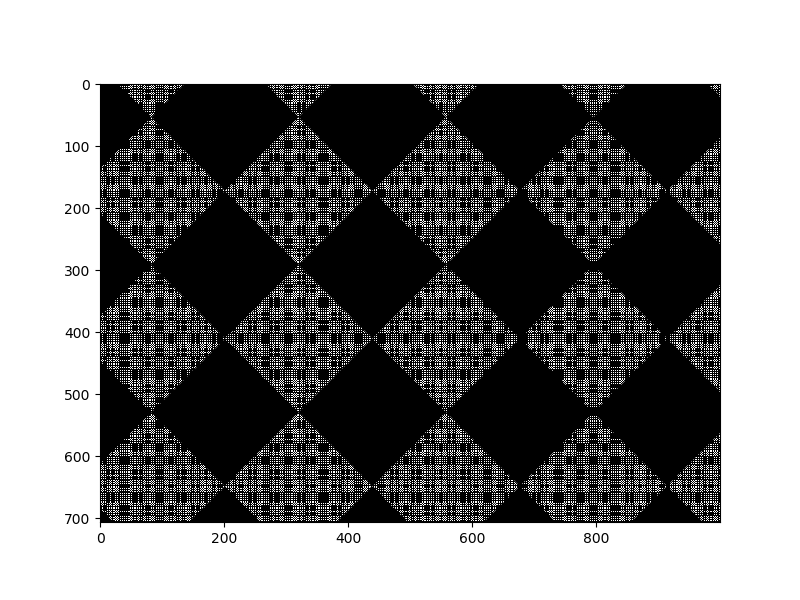

In [15]:
# Copy values to new image I'(x, y)
canvas = np.zeros_like(image)
canvas[ypix2, xpix2] = image[ypix1, xpix1]
show_image(canvas)

In [21]:
#inverse warp
# set up pixel coordinate I'(x, y)
coords = get_grid(width, height, True)
x2, y2 = coords[0], coords[1]

# Apply inverse transform and round it (nearest neighbour interpolation)
warp_coords = (Ainv@coords).astype(np.int)
x1, y1 = warp_coords[0, :], warp_coords[1, :]

# Get pixels within image boundaries
indices = np.where((x1 >= 0) & (x1 < width) &
                   (y1 >= 0) & (y1 < height))

xpix1, ypix1 = x2[indices], y2[indices]
xpix2, ypix2 = x1[indices], y1[indices]

<IPython.core.display.Javascript object>


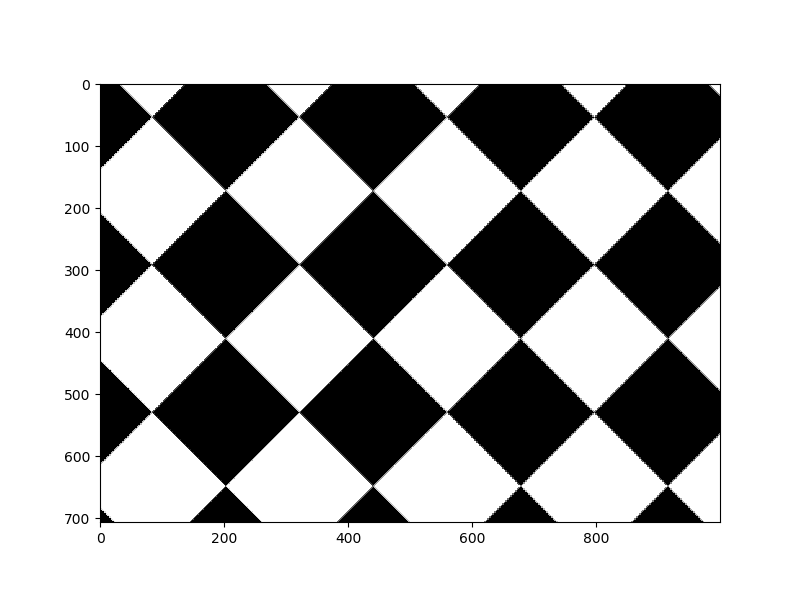

In [22]:
# Map Correspondence
canvas = np.zeros_like(image)
canvas[ypix1, xpix1] = image[ypix2,xpix2]
show_image(canvas)


In [ ]:
'''Estimate homogrpahy'''

<IPython.core.display.Javascript object>


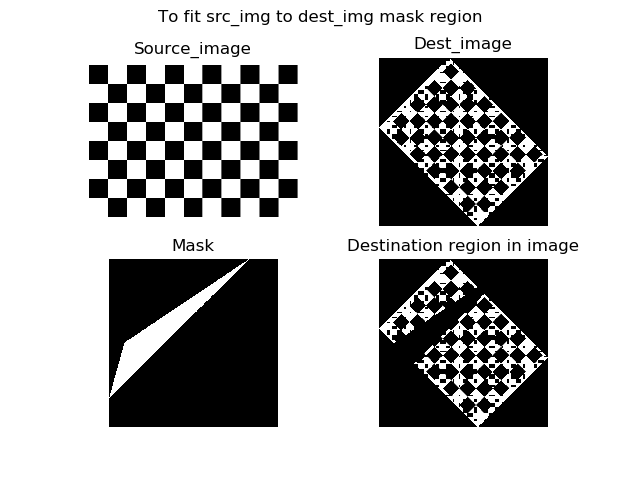

-------
-------
[[ 9.26745697e+02  9.26745697e+02  1.00000000e+03 -1.27985404e-11]
 [ 1.16515888e+03  1.16515888e+03  7.07000001e+02  7.07000000e+02]
 [ 1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00]]
-------
[[   0 1000 1000    0]
 [   0    0  707  707]]
(array([[ 2.71009684e+00,  7.45276631e-01, -7.45276631e+02],
       [ 6.82127888e-01, -7.07000000e-01,  7.07000000e+02],
       [ 9.64820209e-04, -1.00000000e-03,  1.00000000e+00]]), array([[1],
       [1],
       [1],
       [1]], dtype=uint8))
-------
[[ 4.79142398e-06  1.31764171e-06 -1.31764167e-03]
 [-7.06997544e-01 -7.07000000e-01  7.07000000e+02]
 [-9.99996526e-04 -1.00000000e-03  1.00000000e+00]]
[[1000.    0.    1.]
 [ 998.    1.    1.]
 [ 999.    1.    1.]
 ...
 [   0.  999.    1.]
 [   1.  999.    1.]
 [   0. 1000.    1.]]
(0, 2)
(0, 2)
(0, 2)
(0, 2)


<IPython.core.display.Javascript object>


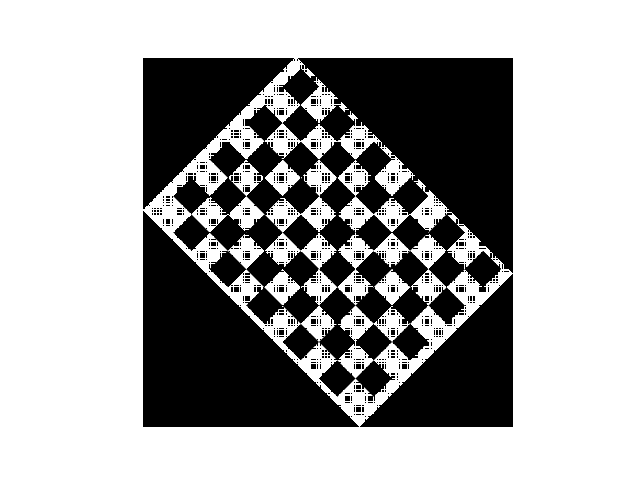

In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


def calculate_homography(in_pts, out_pts):
    """
    in_pts = H*out_pts
    :param in_pts: correspond to src
    :param out_pts:
    :return:
    """

    if isinstance(in_pts, list):
        in_pts = np.array(in_pts)

    if isinstance(out_pts, list):
        out_pts = np.array(out_pts)

    mat_A, mat_b = build_sys_equations(in_pts, out_pts)

    H = np.matmul(np.linalg.pinv(mat_A), mat_b)

    # print(mat_b)
    #
    # print(np.matmul(mat_A, H))

    H = np.reshape(np.hstack((H,1)), (3,3))

    return H

def convert_to_homogenous_crd(inp, axis=1):

    if isinstance(inp, list):
        inp = np.array(inp)

    r, c = inp.shape

    if axis == 1:
        out = np.concatenate((inp, np.ones((r, 1))), axis=axis)
    else:
        out = np.concatenate((inp, np.ones((1, c))), axis=axis)

    return out

def get_pixel_coord(mask):
    """
    Function to get x, y coordinates of white pixels in mask as homogenous coordinates
    :param mask:
    :return:
    """
    y, x = np.where(mask)
    pts = np.concatenate((x[:,np.newaxis], y[:, np.newaxis], np.ones((x.size, 1))), axis=1) # rows of [x1, y1, 1]
    print(pts)

    return pts


def fit_image_in_target_space(img_src, img_dst, mask, H, offset=np.array([0, 0, 0])):
    """
    :param img_src: source image
    :param img_dst: destination image
    :param mask: mask corresponding to dest image
    :param H: pts_in_src_img = H * pts_in_dst_img
    :param offset: np array [x_offset, y_offset, 0]. Offset 0,0 in mask to this value
    :return:
    """

    pts = get_pixel_coord(mask)  # rows of [x1, y1, 1]

    pts = pts + offset

    out_src = np.matmul(H, pts.T)  # out_src has cols of [x1, y1, z1]

    out_src = out_src/out_src[-1,:]
    # print(out_src[-1,:])
    # print(out_src[:,0])

    # Return only x, y non-homogenous coordinates
    out_src = out_src[0:2, :]  # corresponds to pixels in img_src
    out_src = out_src.T  # rows of [x1, y1]

    # Convert pts to out_src convention
    pts = pts[:, 0:2].astype(np.int64)  # Corresponds to pixel locs in img_dst, rows of [x1,y1]

    h, w, _ = img_src.shape

    get_pixel_val(img_dst, img_src, pts, out_src, offset)

    # # x -> c  y -> r
    #  for i in range(out_src.shape[0]):
    #      if (0 <= out_src[i,0] < w-1) and (0 <= out_src[i,1] < h-1):
    #          img_dst[pts[i,1], pts[i,0], :] = get_pixel_val(out_src[i], img_src)


    return img_dst

def get_pixel_val(img_dst, img_src, pts, out_src, offset):
    """
    :param img_dst:
    :param pts: pts for img_dst rows of [x1, y1]
    :param out_src: rows of [x1, y1], corresponding pts in src img after homography on dst points
    :return:
    """
    h, w, _ = img_src.shape
    tl = np.floor(out_src[:, ::-1]).astype(np.int64) # reverse cols to get row, col notation
    br = np.ceil(out_src[:, ::-1]).astype(np.int64)

    pts = pts - offset[:2]

    r_lzero = np.where(~np.logical_or(np.any(tl < 0, axis=1), np.any(br < 0, axis=1)))
    pts = pts[r_lzero[0], :]
    out_src = out_src[r_lzero[0], :]
    tl = tl[r_lzero[0], :]
    br = br[r_lzero[0], :]

    r_fl = np.where(~np.logical_or(tl[:, 0] >= h-1, tl[:, 1] >= w-1))
    pts = pts[r_fl[0], :]
    out_src = out_src[r_fl[0], :]
    tl = tl[r_fl[0], :]
    br = br[r_fl[0], :]

    r_ce = np.where(~np.logical_or(br[:, 0] >= h-1, br[:, 1] >= w-1))
    pts = pts[r_ce[0], :]
    out_src = out_src[r_ce[0], :]
    tl = tl[r_ce[0], :]
    br = br[r_ce[0], :]

    print(pts.shape)
    print(out_src.shape)
    print(tl.shape)
    print(br.shape)

    tr = np.concatenate((tl[:, 0:1], br[:, 1:2]), axis=1)

    bl = np.concatenate((br[:, 0:1], tl[:, 1:2]), axis=1)

    weight = np.zeros((out_src.shape[0], 4))

    weight[:, 0] = np.linalg.norm(tl-out_src[:, ::-1], axis=1)
    weight[:, 1] = np.linalg.norm(tr-out_src[:, ::-1], axis=1)
    weight[:, 2] = np.linalg.norm(bl-out_src[:, ::-1], axis=1)
    weight[:, 3] = np.linalg.norm(br - out_src[:, ::-1], axis=1)

    weight[np.all(weight == 0, axis=1)] = 1  # For entries where they exactly overlap
    weight = 1/weight

    # pts = pts - offset[:2]

    img_dst[pts[:,1], pts[:,0], :] = (img_src[tl[:,0], tl[:,1], :] * weight[:, 0:1] + \
                                     img_src[tr[:,0], tr[:,1], :] * weight[:, 1:2] + \
                                     img_src[bl[:,0], bl[:,1], :] * weight[:, 2:3] + \
                                     img_src[br[:,0], br[:,1], :] * weight[:, 3:4])/ np.sum(weight, axis=1, keepdims=True)


    return img_dst



def build_sys_equations(in_pts, out_pts):
    """
    :param in_pts: nparray [[x1, y1], [x2, y2], ...]
    :param out_pts: nparray [[x1, y1], [x2, y2], ...]
    :param include_perp_bisector:
    :return:
    """

    mat_A = np.zeros((np.size(in_pts), 8))
    mat_b = in_pts.ravel()

    i = 0
    for x, y in out_pts:
        # x row
        mat_A[i][0:3] = [x, y, 1]
        mat_A[i][-2:] = [-x*mat_b[i], -y*mat_b[i]]

        # y row
        mat_A[i+1][-5:] = [x, y, 1, -x*mat_b[i+1], -y*mat_b[i+1]]

        # row counter
        i = i+2

    return mat_A, mat_b


def get_perp_bisectors(in_pts, out_pts):

    perp_in = np.array([in_pts[-1] + in_pts[0],
                        in_pts[0] + in_pts[1],
                        in_pts[1] + in_pts[2],
                        in_pts[2] + in_pts[3]])

    perp_out = np.array([out_pts[-1] + out_pts[0],
                         out_pts[0] + out_pts[1],
                         out_pts[1] + out_pts[2],
                         out_pts[2] + out_pts[3]])

    in_pts = np.concatenate((in_pts, perp_in / 2), axis=0)
    out_pts = np.concatenate((out_pts, perp_out / 2), axis=0)

    in_pts = in_pts.astype(np.int64)
    out_pts = out_pts.astype(np.int64)

    return in_pts, out_pts




def run_main(img_src_path, img_dst_path, out_pts, include_perp=False, save_fig='result.jpg'):
    """
    Fit img_src into img_dst. in_pts are in img_src, out_pts are in img_dst (clkwise starting from top left)
    :param img_1_path:
    :param img_2_path:
    :param in_pts: pts chosen in source image
    :param out_pts: corresponding pts chosen in destination image
    :return:
    """

    fldr, fname = os.path.split(img_src_path)
    _, fname = os.path.split(img_dst_path)

    res_dir = os.path.join(fldr, 'results')
    if not os.path.exists(res_dir):
        os.makedirs(res_dir)

    img_src = cv2.cvtColor(cv2.imread(img_src_path), cv2.COLOR_BGR2RGB)
    img_dst = cv2.cvtColor(cv2.imread(img_dst_path), cv2.COLOR_BGR2RGB)


    if isinstance(out_pts, list):
        out_pts = np.array(out_pts)

    h, w, _ = np.shape(img_src)
    in_pts = np.array([[0, 0], [w, 0], [w, h], [0, h]])

    # Get mask
    mask = np.zeros(img_dst.shape[0:2], dtype=np.uint8)
    cv2.fillConvexPoly(mask, out_pts, 255)
    plot_req_images(img_src, img_dst, mask, os.path.join(res_dir, 'visualize_' + fname))

    if include_perp:
        in_pts, out_pts = get_perp_bisectors(in_pts, out_pts)

    H = calculate_homography(in_pts, out_pts)

    ## Check if homography correctly calculated
    print('-------')
    t_one = np.ones((in_pts.shape[0],1))
    t_out_pts = np.concatenate((out_pts, t_one), axis=1)
    print('-------')
    x = np.matmul(H, t_out_pts.T)
    x = x/x[-1,:]
    print(x)
    print('-------')
    print(in_pts.T)

    print(cv2.findHomography(out_pts, in_pts))
    print('-------')
    print(H)

    out = fit_image_in_target_space(img_src, img_dst, mask, H)
    plt.figure()
    plt.imshow(out)
    plt.axis('off')
    plt.savefig(os.path.join(res_dir, 'result_' + fname))

    plt.show()




def plot_req_images(img_src, img_dst, mask, figName):

    plt.figure()
    plt.suptitle("To fit src_img to dest_img mask region")

    plt.subplot(2, 2, 1)
    plt.title("Source_image")
    plt.imshow(img_src)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.title("Dest_image")
    plt.imshow(img_dst)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(mask, cmap='gray', vmin=0, vmax=255)
    plt.title("Mask")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(cv2.bitwise_and(img_dst, img_dst, mask=~mask))
    plt.title("Destination region in image")
    plt.axis('off')
    plt.savefig(figName)

    plt.show()





if __name__ == "__main__":

    img_src_path = 'a4-checkerboard.png'
    img_dst_path = 'rotated_image22.png'

    out_pts = [[0, 1000], [0, 1000], [1000, 0], [110,600]]  #PQSR

    run_main(img_src_path, img_dst_path, out_pts, False)

    

In [ ]:
###########################            Homography transform            ################################################